In [1]:
import torch
import numpy as np
from PIL import Image
import torch.nn as nn
from datasets import load_dataset
from torchvision import transforms
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler


/run/media/zeromeout/New Volume/Projects/ReceiptScanner/receiptscannerenv/lib64/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
## Load the dataset
ds = load_dataset("naver-clova-ix/cord-v1")
ds

DatasetDict({
    train: Dataset({
        features: ['image', 'ground_truth'],
        num_rows: 800
    })
    validation: Dataset({
        features: ['image', 'ground_truth'],
        num_rows: 100
    })
    test: Dataset({
        features: ['image', 'ground_truth'],
        num_rows: 100
    })
})

In [3]:
## I want to make a preprocessing function
## It would take the image, pass it through a resnet for feature extraction 
## These extracted features would be used in the SVM

class FeatureExtractor(nn.Module):
    def __init__(self, output_layer="layer4"):
        super().__init__()
        pretrained = torch.hub.load("pytorch/vision", "resnet50", weights="IMAGENET1K_V2")
        layers = []
        for name, layer in pretrained.named_children():
            layers.append(layer)
            if name == output_layer:
                break
        self.net = nn.Sequential(*layers)
        del pretrained

    def forward(self, x):
        return self.net(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FeatureExtractor(output_layer="layer4").to(device)
model.eval()


def preprocess_image(image, target_size=(224, 224)):
    """
    Preprocess an image and extract ResNet features for SVM input.
    """
    if isinstance(image, np.ndarray):
        image = Image.fromarray((image * 255).astype(np.uint8))  # convert numpy -> PIL
    
    preprocess = transforms.Compose([
        transforms.Resize(target_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
    ])

    # Prepare tensor
    img_tensor = preprocess(image).unsqueeze(0).to(device)

    # Extract features
    with torch.no_grad():
        features = model(img_tensor)

    # Flatten to 1D feature vector
    features = torch.flatten(features, start_dim=1).cpu().numpy().squeeze()
    return features



Using cache found in /home/zeromeout/.cache/torch/hub/pytorch_vision_main


In [11]:
## Training
train_images = [] 

for img in ds['train']['image']: 
    train_images.append(preprocess_image(img))

train_images = np.array(train_images)

scaler = StandardScaler()

train_images_scaled = scaler.fit_transform(train_images) 
clf = OneClassSVM(kernel='rbf', nu=0.1, gamma='scale') 
clf.fit(train_images_scaled)

,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,tol,0.001
,nu,0.1
,shrinking,True
,cache_size,200
,verbose,False
,max_iter,-1


In [12]:
## Validation
validation_images = [] 

for img in ds['validation']['image']: 
    validation_images.append(preprocess_image(img)) 

validation_images = np.array(validation_images)

validation_images_scaled = scaler.transform(validation_images) 

predictions = clf.predict(validation_images_scaled)
outliers = np.where(predictions == -1)[0] 
inliers = np.where(predictions == 1)[0] 

print(f"Number of outliers in validation set: {len(outliers)}") 
print(f"Number of inliers in validation set: {len(inliers)}")

Number of outliers in validation set: 61
Number of inliers in validation set: 39


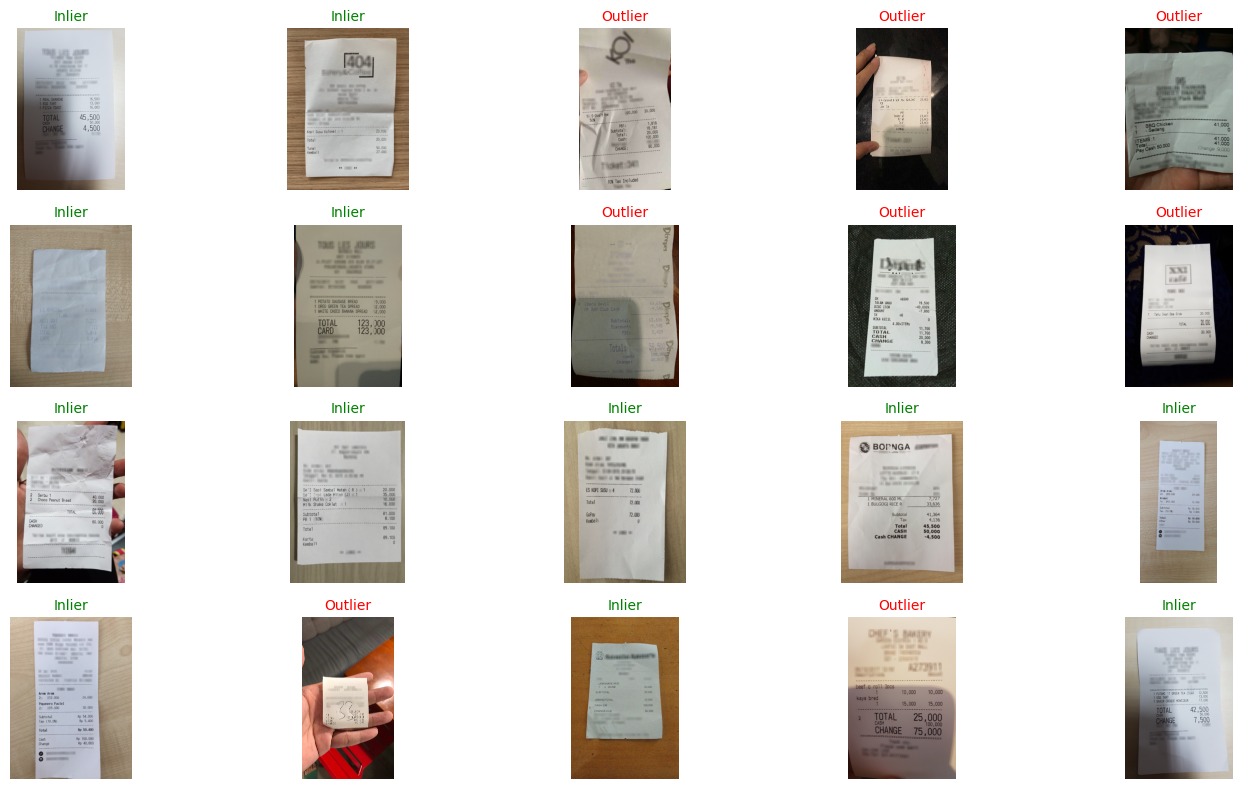

In [13]:
import matplotlib.pyplot as plt

# Assume you already have:
# validation_images (list of NumPy arrays or tensors)
# predictions (array of -1 for outliers, 1 for inliers)

# Convert dataset images to numpy arrays (if they're tensors or PIL)
imgs = [np.array(img) for img in ds['validation']['image']]

# Plot settings
n_show = 20  # how many images to display
cols = 5
rows = n_show // cols + int(n_show % cols != 0)

plt.figure(figsize=(15, 8))

for i in range(n_show):
    ax = plt.subplot(rows, cols, i + 1)
    img = imgs[i]
    label = "Outlier" if predictions[i] == -1 else "Inlier"

    # Show image
    plt.imshow(img)
    plt.title(label, color=("red" if label == "Outlier" else "green"), fontsize=10)
    plt.axis("off")

plt.tight_layout()
plt.show()


In [14]:
## Testing
test_images = [] 

for img in ds['test']['image']: 
    test_images.append(preprocess_image(img)) 

test_images = np.array(test_images)

test_images_scaled = scaler.transform(test_images) 

predictions = clf.predict(test_images_scaled)
outliers = np.where(predictions == -1)[0] 
inliers = np.where(predictions == 1)[0] 

print(f"Number of outliers in test set: {len(outliers)}") 
print(f"Number of inliers in test set: {len(inliers)}")

Number of outliers in test set: 77
Number of inliers in test set: 23


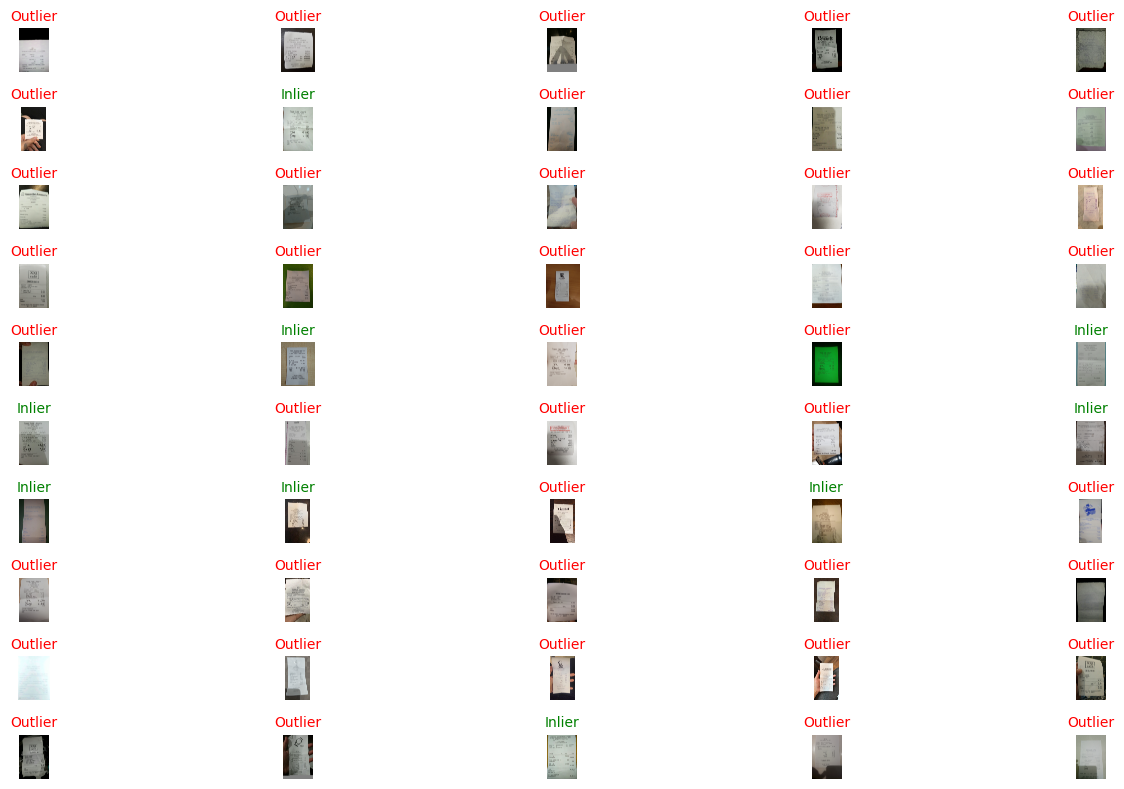

In [15]:
imgs = [np.array(img) for img in ds['test']['image']]

# Plot settings
n_show = 50  # how many images to display
cols = 5
rows = n_show // cols + int(n_show % cols != 0)

plt.figure(figsize=(15, 8))

for i in range(n_show):
    ax = plt.subplot(rows, cols, i + 1)
    img = imgs[i]
    label = "Outlier" if predictions[i] == -1 else "Inlier"

    # Show image
    plt.imshow(img)
    plt.title(label, color=("red" if label == "Outlier" else "green"), fontsize=10)
    plt.axis("off")

plt.tight_layout()
plt.show()